In [1]:
!pip install evaluate einops livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency 

In [2]:
!git clone https://github.com/NX-AI/vision-lstm.git

Cloning into 'vision-lstm'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (613/613), done.
remote: Compressing objects: 100% (438/438), done.
remote: Total 613 (delta 189), reused 574 (delta 150), pack-reused 0
Receiving objects: 100% (613/613), 888.34 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from livelossplot import PlotLosses

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ensure dataset classes are defined for confusion matrix
dataset_classes = datasets.CIFAR10(root='./data', train=True).classes

100%|██████████| 170498071/170498071 [00:13<00:00, 12808283.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# xLSTM Implementation from Vision-LSTM Repository
import sys
sys.path.append('/content/vision-lstm')

from vision_lstm.vision_lstm import VisionLSTM

# Initialize xLSTM with similar parameters to ViT
xLSTM_model = VisionLSTM(
    dim=768,  # Latent dimension
    depth=12,  # Number of ViL blocks
    patch_size=16,  # Patch size
    input_shape=(3, 224, 224),  # RGB images with resolution 224x224 for CIFAR-10
    output_shape=(10,),  # Classifier with 10 classes
    drop_path_rate=0.05  # Stochastic depth parameter
)
xLSTM_model = xLSTM_model.to(device)

# Define ViT model
from transformers import ViTForImageClassification, ViTConfig

config = ViTConfig(
    num_labels=10,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    intermediate_size=3072,
    image_size=224,
    patch_size=16,
)

vit_model = ViTForImageClassification(config).to(device)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

xLSTM_optimizer = optim.AdamW(xLSTM_model.parameters(), lr=5e-5)
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=5e-5)

# Function to get model size
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# Updated train_model function with livelossplot for real-time plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, is_vit=False):
    liveloss = PlotLosses()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    start_time = time.time()
    for epoch in range(num_epochs):
        logs = {}

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                if is_vit:
                    outputs = model(images).logits  # Accessing logits attribute for ViT
                else:
                    outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(correct_train / total_train)

        val_loss, val_accuracy, _ = evaluate_model(model, val_loader, is_vit)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        logs['accuracy'] = train_accuracies[-1]
        logs['val_accuracy'] = val_accuracies[-1]
        logs['loss'] = train_losses[-1]
        logs['val_loss'] = val_losses[-1]

        liveloss.update(logs)
        liveloss.send()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {correct_train / total_train:.4f}')
        training_time = time.time() - start_time
        return training_time, train_losses, val_losses, train_accuracies, val_accuracies

# Updated evaluate_model function
def evaluate_model(model, data_loader, is_vit=False):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            if is_vit:
                outputs = model(images).logits  # Accessing logits attribute for ViT
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = evaluate.load("accuracy")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")

    accuracy_result = accuracy.compute(predictions=np.array(all_preds), references=np.array(all_labels))
    precision_result = precision.compute(predictions=np.array(all_preds), references=np.array(all_labels), average="weighted")
    recall_result = recall.compute(predictions=np.array(all_preds), references=np.array(all_labels), average="weighted")
    f1_result = f1.compute(predictions=np.array(all_preds), references=np.array(all_labels), average="weighted")

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct / total

    print("Evaluation Results:")
    print(f"Accuracy: {accuracy_result['accuracy']:.4f}")
    print(f"Precision: {precision_result['precision']:.4f}")
    print(f"Recall: {recall_result['recall']:.4f}")
    print(f"F1 Score: {f1_result['f1']:.4f}")

    return epoch_loss, epoch_accuracy, {
        'accuracy': accuracy_result['accuracy'],
        'precision': precision_result['precision'],
        'recall': recall_result['recall'],
        'f1': f1_result['f1']
    }

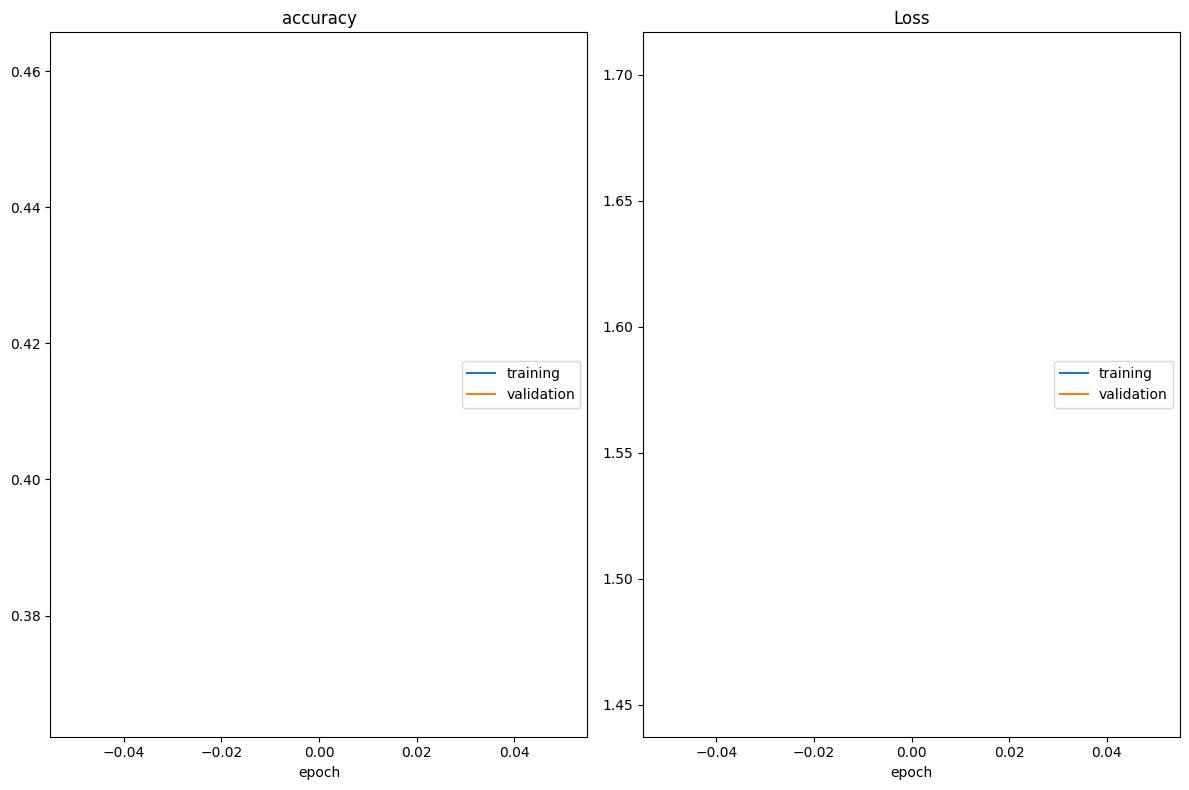

accuracy
	training         	 (min:    0.367, max:    0.367, cur:    0.367)
	validation       	 (min:    0.461, max:    0.461, cur:    0.461)
Loss
	training         	 (min:    1.704, max:    1.704, cur:    1.704)
	validation       	 (min:    1.450, max:    1.450, cur:    1.450)
Epoch [1/10], Loss: 1.7041, Accuracy: 0.3669
CPU times: user 10min 5s, sys: 1.44 s, total: 10min 7s
Wall time: 5min 1s
Evaluation Results:
Accuracy: 0.4628
Precision: 0.4750
Recall: 0.4628
F1 Score: 0.4487


In [7]:
# Train and evaluate ViT model
print("Training ViT Model")
%time vit_training_time, vit_train_losses, vit_val_losses, vit_train_accuracies, vit_val_accuracies = train_model(vit_model, train_loader, val_loader, criterion, vit_optimizer, num_epochs=10, is_vit=True)
vit_test_loss, vit_test_accuracy, vit_metrics = evaluate_model(vit_model, test_loader, is_vit=True)
vit_model_size = get_model_size(vit_model)
vit_params = sum(p.numel() for p in vit_model.parameters())

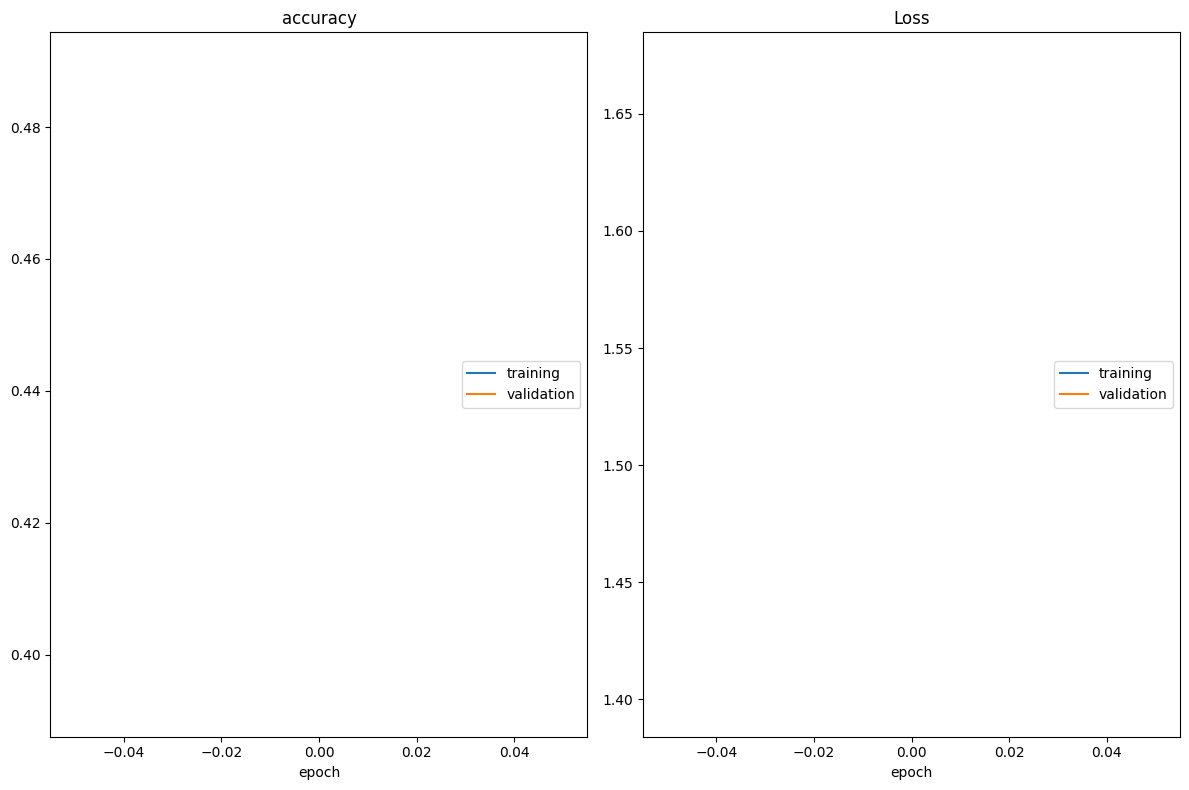

accuracy
	training         	 (min:    0.392, max:    0.392, cur:    0.392)
	validation       	 (min:    0.489, max:    0.489, cur:    0.489)
Loss
	training         	 (min:    1.671, max:    1.671, cur:    1.671)
	validation       	 (min:    1.398, max:    1.398, cur:    1.398)
Epoch [1/10], Loss: 1.6712, Accuracy: 0.3924
CPU times: user 12min 49s, sys: 1min 15s, total: 14min 4s
Wall time: 8min 59s
Evaluation Results:
Accuracy: 0.4861
Precision: 0.4961
Recall: 0.4861
F1 Score: 0.4724


In [8]:
# Train and evaluate xLSTM model
print("Training xLSTM Model")
%time xLSTM_training_time, xLSTM_train_losses, xLSTM_val_losses, xLSTM_train_accuracies, xLSTM_val_accuracies = train_model(xLSTM_model, train_loader, val_loader, criterion, xLSTM_optimizer, num_epochs=10, is_vit=False)
xLSTM_test_loss, xLSTM_test_accuracy, xLSTM_metrics = evaluate_model(xLSTM_model, test_loader, is_vit=False)
xLSTM_model_size = get_model_size(xLSTM_model)
xLSTM_params = sum(p.numel() for p in xLSTM_model.parameters())

                 Metric     xLSTM       ViT
0              Accuracy    0.4861    0.4628
1             Precision    0.4961     0.475
2                Recall    0.4861    0.4628
3              F1 Score    0.4724    0.4487
4       Model Size (MB)    167.92    327.33
5  Number of Parameters  44019562  85806346
6   Training Time (m:s)      8:59       5:1


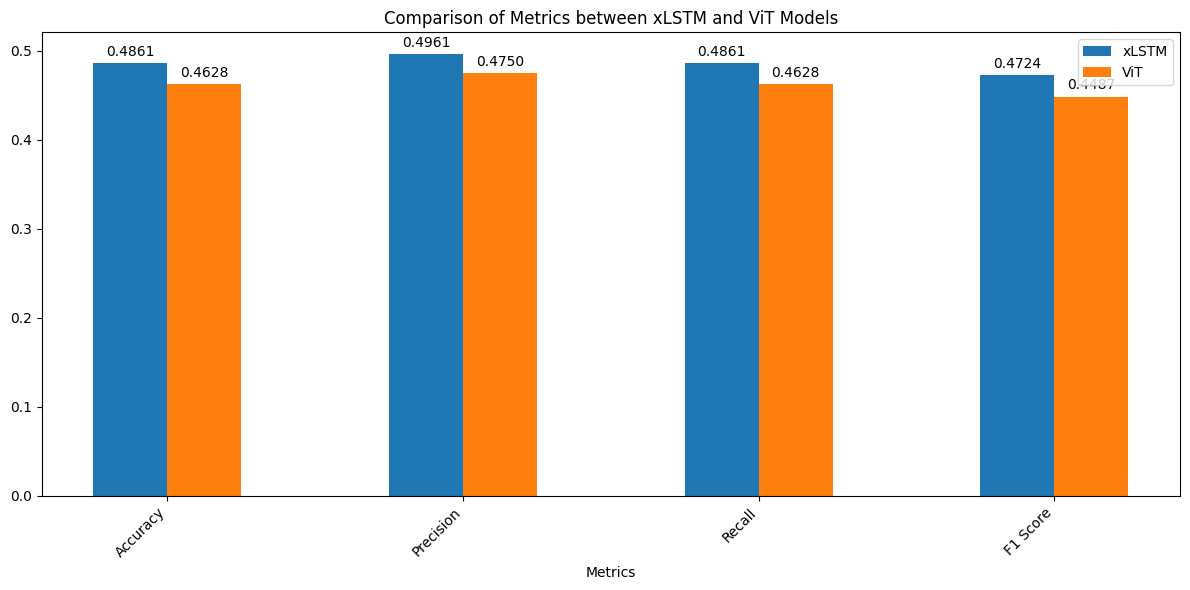

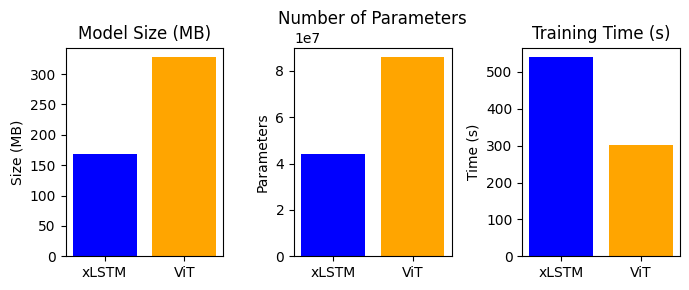

In [9]:
# Convert training time to minutes and seconds
xLSTM_training_time_minutes = divmod(xLSTM_training_time, 60)
vit_training_time_minutes = divmod(vit_training_time, 60)

# Generate comparison table
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (MB)', 'Number of Parameters', 'Training Time (m:s)'],
    'xLSTM': [
        round(xLSTM_metrics['accuracy'], 4),
        round(xLSTM_metrics['precision'], 4),
        round(xLSTM_metrics['recall'], 4),
        round(xLSTM_metrics['f1'], 4),
        round(xLSTM_model_size, 2),
        xLSTM_params,
        f"{int(xLSTM_training_time_minutes[0])}:{int(xLSTM_training_time_minutes[1])}"
    ],
    'ViT': [
        round(vit_metrics['accuracy'], 4),
        round(vit_metrics['precision'], 4),
        round(vit_metrics['recall'], 4),
        round(vit_metrics['f1'], 4),
        round(vit_model_size, 2),
        vit_params,
        f"{int(vit_training_time_minutes[0])}:{int(vit_training_time_minutes[1])}"
    ]
}

df = pd.DataFrame(data)
print(df)

# Plot metrics comparison
metrics_mapping = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1 Score': 'f1'
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
xLSTM_values = [xLSTM_metrics[metrics_mapping[m]] for m in metrics]
vit_values = [vit_metrics[metrics_mapping[m]] for m in metrics]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, xLSTM_values, width, label='xLSTM')
rects2 = ax.bar(x + width/2, vit_values, width, label='ViT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Metrics between xLSTM and ViT Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.legend()

# Adding values on top of the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

fig.tight_layout()

plt.show()

# Plot separate small graphs for model size, number of parameters, and training time
fig, axes = plt.subplots(1, 3, figsize=(7, 3))

# Model Size
axes[0].bar(['xLSTM', 'ViT'], [xLSTM_model_size, vit_model_size], color=['blue', 'orange'])
axes[0].set_title('Model Size (MB)')
axes[0].set_ylabel('Size (MB)')

# Number of Parameters
axes[1].bar(['xLSTM', 'ViT'], [xLSTM_params, vit_params], color=['blue', 'orange'])
axes[1].set_title('Number of Parameters')
axes[1].set_ylabel('Parameters')

# Training Time
axes[2].bar(['xLSTM', 'ViT'], [xLSTM_training_time_minutes[0]*60 + xLSTM_training_time_minutes[1], vit_training_time_minutes[0]*60 + vit_training_time_minutes[1]], color=['blue', 'orange'])
axes[2].set_title('Training Time (s)')
axes[2].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

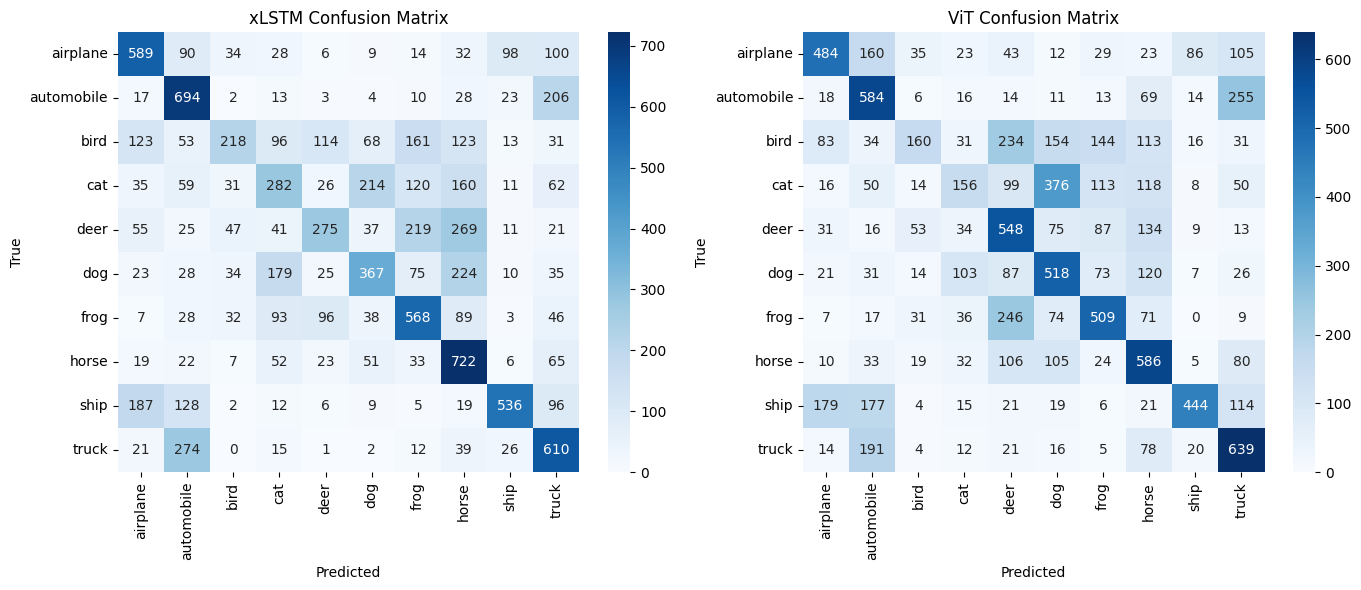

In [10]:
# Plot confusion matrix for xLSTM
all_preds = []
all_labels = []
xLSTM_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = xLSTM_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

xLSTM_conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix for ViT
all_preds = []
all_labels = []
vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits  # Accessing logits attribute
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

vit_conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(xLSTM_conf_matrix, annot=True, fmt='d', xticklabels=dataset_classes, yticklabels=dataset_classes, cmap="Blues", ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('xLSTM Confusion Matrix')

sns.heatmap(vit_conf_matrix, annot=True, fmt='d', xticklabels=dataset_classes, yticklabels=dataset_classes, cmap="Blues", ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('ViT Confusion Matrix')

plt.tight_layout()
plt.show()

xLSTM Classification Report
              precision    recall  f1-score   support

    airplane       0.55      0.59      0.57      1000
  automobile       0.50      0.69      0.58      1000
        bird       0.54      0.22      0.31      1000
         cat       0.35      0.28      0.31      1000
        deer       0.48      0.28      0.35      1000
         dog       0.46      0.37      0.41      1000
        frog       0.47      0.57      0.51      1000
       horse       0.42      0.72      0.53      1000
        ship       0.73      0.54      0.62      1000
       truck       0.48      0.61      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.47     10000
weighted avg       0.50      0.49      0.47     10000



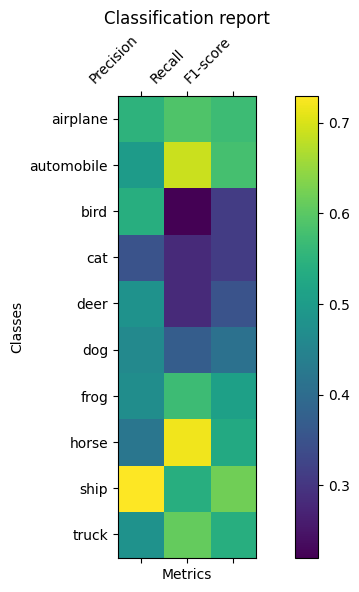

ViT Classification Report
              precision    recall  f1-score   support

    airplane       0.56      0.48      0.52      1000
  automobile       0.45      0.58      0.51      1000
        bird       0.47      0.16      0.24      1000
         cat       0.34      0.16      0.21      1000
        deer       0.39      0.55      0.45      1000
         dog       0.38      0.52      0.44      1000
        frog       0.51      0.51      0.51      1000
       horse       0.44      0.59      0.50      1000
        ship       0.73      0.44      0.55      1000
       truck       0.48      0.64      0.55      1000

    accuracy                           0.46     10000
   macro avg       0.48      0.46      0.45     10000
weighted avg       0.48      0.46      0.45     10000



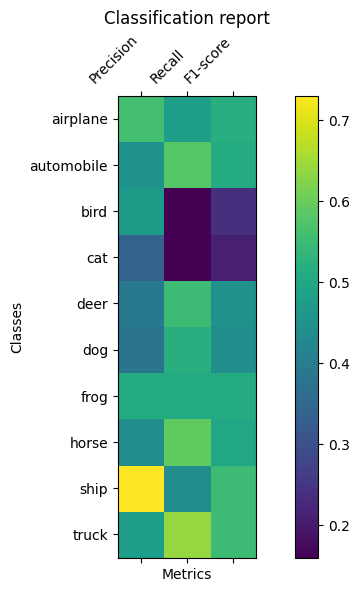

In [11]:
# Function to plot classification report
def plot_classification_report(report, title='Classification report', cmap='viridis'):
    lines = report.split('\n')

    classes, plot_mat, support, class_names = [], [], [], []
    for line in lines[2:(len(lines) - 3)]:
        t = line.split()
        if len(t) < 5:  # Skip lines that don't have the expected number of columns
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1:len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plot_mat.append(v)

    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.matshow(plot_mat, cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticks(range(len(['Precision', 'Recall', 'F1-score'])))
    ax.set_xticklabels(['Precision', 'Recall', 'F1-score'], rotation=45, ha="right")
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)

    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

# Generate classification report for xLSTM
all_preds = []
all_labels = []
xLSTM_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = xLSTM_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

xLSTM_report = classification_report(all_labels, all_preds, target_names=dataset_classes, output_dict=False)
print("xLSTM Classification Report")
print(xLSTM_report)
plot_classification_report(classification_report(all_labels, all_preds, target_names=dataset_classes))

# Generate classification report for ViT
all_preds = []
all_labels = []
vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits  # Accessing logits attribute
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

vit_report = classification_report(all_labels, all_preds, target_names=dataset_classes, output_dict=False)
print("ViT Classification Report")
print(vit_report)
plot_classification_report(classification_report(all_labels, all_preds, target_names=dataset_classes))

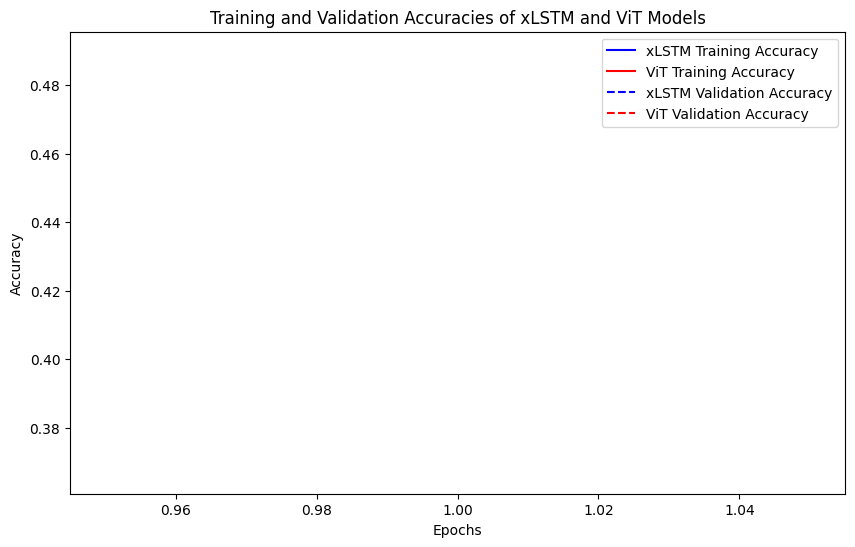

In [12]:
# Plot comparison of training and validation accuracies for xLSTM and ViT models
epochs = range(1, len(xLSTM_train_accuracies) + 1)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot training accuracies
ax.plot(epochs, xLSTM_train_accuracies, 'b-', label='xLSTM Training Accuracy')
ax.plot(epochs, vit_train_accuracies, 'r-', label='ViT Training Accuracy')

# Plot validation accuracies
ax.plot(epochs, xLSTM_val_accuracies, 'b--', label='xLSTM Validation Accuracy')
ax.plot(epochs, vit_val_accuracies, 'r--', label='ViT Validation Accuracy')

# Add labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracies of xLSTM and ViT Models')
ax.legend()

# Show the plot
plt.show()